In [ ]:
import numpy as np
import pandas as pd
import os
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
import albumentations as A

In [ ]:
# Define function to apply weather effects
def apply_weather_effect(image, effect_type="rain"):
    if effect_type == "rain":
        transform = A.RandomRain(brightness_coefficient=0.9, drop_width=1, blur_value=3, p=1)
    elif effect_type == "snow":
        transform = A.RandomSnow(brightness_coeff=2.5, snow_point_lower=0.3, snow_point_upper=0.5, p=1)
    return transform(image=image)['image']

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load dataset
image_data_dir = "/content/drive/My Drive/CNN/Dataset/train_images"
image_filenames = os.listdir(image_data_dir)
labels_data = pd.read_csv("/content/drive/My Drive/CNN/Dataset/labels.csv")

# Preprocess and separate original and augmented data
original_images = []
augmented_images = []
original_labels = []
augmented_labels = []

for filename in image_filenames:
    image_path = os.path.join(image_data_dir, filename)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) if image is not None else None
    if image is not None and filename in labels_data['image_filename'].values:
        label = labels_data[labels_data['image_filename'] == filename]['label'].iloc[0]
        original_images.append(image)
        original_labels.append(label)

        # Randomly decide to augment with weather effects
        if np.random.rand() < 0.5:  # 50% chance to augment
            effect_type = np.random.choice(["rain", "snow"])
            aug_image = apply_weather_effect(image, effect_type=effect_type)
            augmented_images.append(aug_image)
            augmented_labels.append(label)

In [ ]:
# Convert lists to arrays
X_original = np.array(original_images)
y_original = to_categorical(np.array(original_labels))
X_augmented = np.array(augmented_images)
y_augmented = to_categorical(np.array(augmented_labels))

# Combine original and augmented for validation and testing
X_combined = np.concatenate((X_original, X_augmented))
y_combined = np.concatenate((y_original, y_augmented))

# Split into training, validation, and test sets
X_train_orig, X_temp, y_train_orig, y_temp = train_test_split(X_original, y_original, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_combined, y_combined, test_size=0.5, random_state=42)  # Split combined for validation and testing

X_train_aug, _, y_train_aug, _ = train_test_split(X_augmented, y_augmented, test_size=0.3, random_state=42)  # Training set for augmented model

In [ ]:
from tensorflow.keras.applications import ResNet50

# ResNet50 model before fine tuning
def create_model(input_shape, num_classes):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in base_model.layers:
        layer.trainable = False

    model = Sequential([
        base_model,
        Flatten(),
        Dense(64, activation="relu"),
        Dense(num_classes, activation="softmax")
    ])
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model

In [ ]:
# Create and train baseline model
baseline_model = create_model(X_train_orig.shape[1:], y_train_orig.shape[1])
baseline_history = baseline_model.fit(X_train_orig, y_train_orig, epochs=40, validation_data=(X_val, y_val))

Epoch 1/40
21/21 [==============================] - 21s 859ms/step - loss: 16.2234 - accuracy: 0.8674 - val_loss: 10.1041 - val_accuracy: 0.9043
Epoch 2/40
21/21 [==============================] - 11s 540ms/step - loss: 1.9276 - accuracy: 0.9532 - val_loss: 4.1248 - val_accuracy: 0.9043
Epoch 3/40
21/21 [==============================] - 11s 541ms/step - loss: 0.0767 - accuracy: 0.9844 - val_loss: 3.1060 - val_accuracy: 0.8914
Epoch 4/40
21/21 [==============================] - 11s 542ms/step - loss: 0.0549 - accuracy: 0.9875 - val_loss: 2.9134 - val_accuracy: 0.8986
Epoch 5/40
21/21 [==============================] - 11s 543ms/step - loss: 0.0212 - accuracy: 0.9875 - val_loss: 3.0050 - val_accuracy: 0.9014
Epoch 6/40
21/21 [==============================] - 11s 543ms/step - loss: 0.0199 - accuracy: 0.9906 - val_loss: 2.8906 - val_accuracy: 0.9114
Epoch 7/40
21/21 [==============================] - 11s 544ms/step - loss: 0.0196 - accuracy: 0.9938 - val_loss: 2.9099 - val_accuracy: 0.91

In [ ]:
# Create and train augmented model
augmented_model = create_model(X_train_aug.shape[1:], y_train_aug.shape[1])
augmented_history = augmented_model.fit(X_train_aug, y_train_aug, epochs=40, validation_data=(X_val, y_val))

Epoch 1/40
11/11 [==============================] - 17s 1s/step - loss: 25.1085 - accuracy: 0.6302 - val_loss: 0.5567 - val_accuracy: 0.8543
Epoch 2/40
11/11 [==============================] - 9s 837ms/step - loss: 0.6611 - accuracy: 0.7278 - val_loss: 0.6261 - val_accuracy: 0.6814
Epoch 3/40
11/11 [==============================] - 9s 836ms/step - loss: 0.6461 - accuracy: 0.6331 - val_loss: 0.6809 - val_accuracy: 0.5857
Epoch 4/40
11/11 [==============================] - 9s 837ms/step - loss: 0.6592 - accuracy: 0.6183 - val_loss: 0.6789 - val_accuracy: 0.5871
Epoch 5/40
11/11 [==============================] - 9s 836ms/step - loss: 0.6061 - accuracy: 0.6953 - val_loss: 0.9307 - val_accuracy: 0.8071
Epoch 6/40
11/11 [==============================] - 9s 836ms/step - loss: 0.6416 - accuracy: 0.7574 - val_loss: 0.5145 - val_accuracy: 0.8200
Epoch 7/40
11/11 [==============================] - 9s 836ms/step - loss: 0.5769 - accuracy: 0.7219 - val_loss: 0.5600 - val_accuracy: 0.7529
Epoch 8

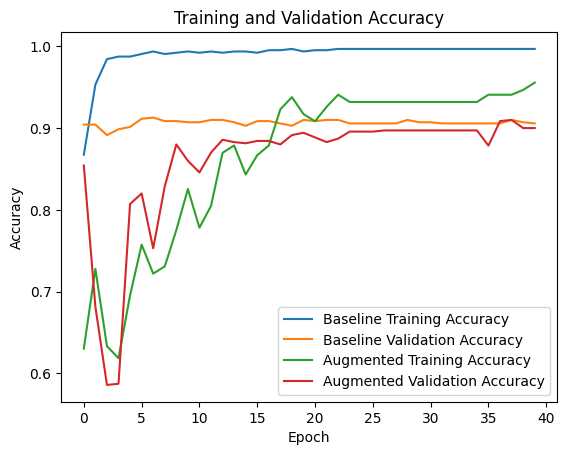

In [ ]:
import matplotlib.pyplot as plt

plt.plot(baseline_history.history['accuracy'], label='Baseline Training Accuracy')
plt.plot(baseline_history.history['val_accuracy'], label='Baseline Validation Accuracy')
plt.plot(augmented_history.history['accuracy'], label='Augmented Training Accuracy')
plt.plot(augmented_history.history['val_accuracy'], label='Augmented Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
# Evaluate both models on the test set
baseline_score = baseline_model.evaluate(X_test, y_test, verbose=0)
augmented_score = augmented_model.evaluate(X_test, y_test, verbose=0)
print("Baseline Model - Test loss:", baseline_score[0], "Test accuracy:", baseline_score[1])
print("Augmented Model - Test loss:", augmented_score[0], "Test accuracy:", augmented_score[1])

Baseline Model - Test loss: 2.413829803466797 Test accuracy: 0.9171428680419922
Augmented Model - Test loss: 0.7127743363380432 Test accuracy: 0.9357143044471741


In [ ]:
pip install keras-tuner

In [ ]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from keras_tuner import RandomSearch

def create_tune_model(hp):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(512, 512, 3))  # Adjusted for your images
    for layer in base_model.layers:
        layer.trainable = False

    model = Sequential([
        base_model,
        Flatten(),
        Dense(hp.Int('units', min_value=32, max_value=128, step=32), activation=hp.Choice('dense_activation', values=['relu', 'tanh', 'sigmoid'])),
        Dropout(hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)),
        Dense(2, activation='softmax')  # Assuming you have 2 classes
    ])

    model.compile(
        optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG')),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [ ]:
tuner = RandomSearch(
    create_tune_model,
    objective='val_accuracy',
    max_trials=10,  # Set the number of trials (model configurations) to test
    executions_per_trial=1,  # Number of models to train per trial
    directory='model_tuning',
    project_name='WeedDetection'
)

# Start tuning with the training data
tuner.search(X_train_aug, y_train_aug, epochs=40, validation_data=(X_val, y_val))

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The best hyperparameters are:
- Units: {best_hps.get('units')}
- Dense Activation: {best_hps.get('dense_activation')}
- Dropout: {best_hps.get('dropout')}
- Learning Rate: {best_hps.get('learning_rate')}
""")

# You can also retrain the model with the best hyperparameters or analyze them further
rstune_model = tuner.get_best_models(num_models=1)[0]

Reloading Tuner from model_tuning/WeedDetection/tuner0.json

The best hyperparameters are:
- Units: 96
- Dense Activation: sigmoid
- Dropout: 0.0
- Learning Rate: 1.3784059518427684e-05



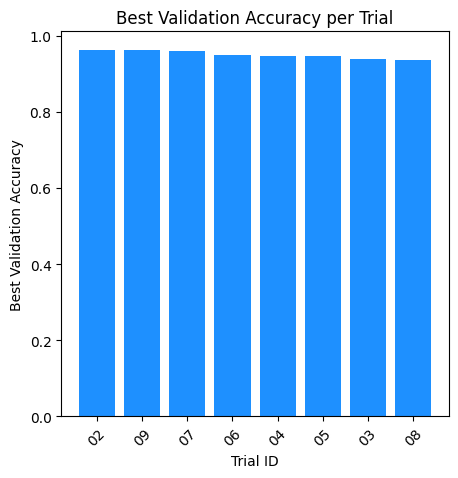

In [ ]:
# Fetch a summary of the trials
trials = tuner.oracle.get_best_trials(num_trials=10)

val_accuracies = [trial.score for trial in trials if trial.score is not None]
trial_ids = [trial.trial_id for trial in trials if trial.score is not None]

plt.figure(figsize=(5, 5))
plt.bar(trial_ids, val_accuracies, color='dodgerblue')
plt.xlabel('Trial ID')
plt.ylabel('Best Validation Accuracy')
plt.title('Best Validation Accuracy per Trial')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Evaluate both models on the test set
RandomSearch_score = rstune_model.evaluate(X_test, y_test, verbose=0)
print("Random Search Model - Test loss:", RandomSearch_score[0], "Test accuracy:", RandomSearch_score[1])

Random Search Model - Test loss: 0.15610362589359283 Test accuracy: 0.9557142853736877


In [ ]:
# Baseline model results before fine-tuning
baseline_test_loss = baseline_score[0]
baseline_test_accuracy = baseline_score[1]

# Augmented model results before fine-tuning
augmented_test_loss = augmented_score[0]
augmented_test_accuracy = augmented_score[1]

# Random search model results after fine-tuning
random_search_test_loss = RandomSearch_score[0]
random_search_test_accuracy = RandomSearch_score[1]

In [ ]:
# Calculate the percentage change in test loss
change_in_test_loss = ((random_search_test_loss - augmented_test_loss) / augmented_test_loss) * 100

# Calculate the percentage change in test accuracy
change_in_test_accuracy = ((random_search_test_accuracy - augmented_test_accuracy) / augmented_test_accuracy) * 100

# Print the results
print(f"Change in Test Loss: {change_in_test_loss:.2f}%")
print(f"Change in Test Accuracy: {change_in_test_accuracy:.2f}%")

Change in Test Loss: -78.10%
Change in Test Accuracy: 2.14%
